En este notebook vemos como usar los `objetos/modelos` que produce la clase scorecard y como hacer predicciones con ellos en dos competiciones de Kaggle 😎

<span style='color:blue'>Importamos los módulos

In [1]:
import numpy as np, pandas as pd, pyken as pyk

<h3><span style='color:blue'>Titanic

In [2]:
df_train = pd.read_csv('train titanic.csv')
L = list(pyk.proc_freq(df_train, 'Survived').frequency)
print('Sobrevivieron {}. Muerieron {} (entre ellos Leonardo DiCaprio)'.format(L[1], L[0]))

Sobrevivieron 342. Muerieron 549 (entre ellos Leonardo DiCaprio)


In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X, y = df_train.drop('Survived', axis=1), df_train.Survived.values

<span style='color:blue'>Sacamos una primera scorecard excluyendo las variables nominativas `PassengerId` y `Name`

In [5]:
modelo_titanic1 = pyk.autoscorecard(excluded_vars=['PassengerId', 'Name']).fit(X, y)

Particionado 70-30 estratificado en el target terminado.
------------------------------------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------------------------------------
Variables no agrupadas: ['Cabin', 'Embarked']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cuidado, has puesto un valor numero máximo de iteraciones (12) superior al número de variables candidatas (7)
------------------------------------------------------------------------------------------------------------------------------------------------------
Step 01 | Time - 0:00:00.086104 | p-value = 8.60e-39 | Gini train = 55.81% | Gini test = 47.7

<span style='color:blue'>Uf, menudo batacazo del train al test... Esto es un claro ejemplo de **sobreajuste**. Miramos a ver si alguna de las 4 variables tiene un IV muy alto y/o es demasiado granular...

In [6]:
modelo_titanic1.tabla_ivs.head(3)

,variable,iv
1,Ticket,7.014385
2,Sex,1.479819
0,Fare,0.704009


<span style='color:blue'>`Ticket` es muy sospechosa (make sense, el billete es una variable categórica demasiado identificativa)

In [7]:
print('Valores distintos variable Ticket: {}'.format(len(X['Ticket'].value_counts())))

Valores distintos variable Ticket: 681


<span style='color:blue'>Sacamos otro modelo ahora sin `Ticket`

In [8]:
modelo_titanic2 = pyk.autoscorecard(excluded_vars=['PassengerId', 'Name', 'Ticket']).fit(X, y)

Particionado 70-30 estratificado en el target terminado.
------------------------------------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------------------------------------
Variables no agrupadas: ['Cabin', 'Embarked']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cuidado, has puesto un valor numero máximo de iteraciones (12) superior al número de variables candidatas (6)
------------------------------------------------------------------------------------------------------------------------------------------------------
Step 01 | Time - 0:00:00.086766 | p-value = 8.60e-39 | Gini train = 55.81% | Gini test = 47.7

<span style='color:blue'>Ya no tenemos tanto desplome, sin embargo sigue existiendo una buena diferencia: una caida del 17.95% de Gini de train a test (no en puntos porcentuales)

In [9]:
print('Caida de Gini de train a test: {:.2f}%'.format(100*(modelo_titanic2.gini_train - modelo_titanic2.gini_test) / modelo_titanic2.gini_train))

Caida de Gini de train a test: 8.49%


<span style='color:blue'>De hecho, podemos ver que en test tenemos mejores Ginis en pasos antes de la inclusión de `Cabin`... De hecho Cabin es muy granular y parecer provocar algo de overfitting

In [10]:
print('Valores distintos variable Cabin: {}'.format(len(X['Cabin'].value_counts())))

Valores distintos variable Cabin: 147


<span style='color:blue'>Sacamos un tercer modelo escluyendo también a `Cabin`

In [11]:
modelo_titanic3 = pyk.autoscorecard(excluded_vars=['PassengerId', 'Name', 'Ticket', 'Cabin']).fit(X, y)

Particionado 70-30 estratificado en el target terminado.
------------------------------------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------------------------------------
Variables no agrupadas: ['Embarked']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cuidado, has puesto un valor numero máximo de iteraciones (12) superior al número de variables candidatas (6)
------------------------------------------------------------------------------------------------------------------------------------------------------
Step 01 | Time - 0:00:00.210692 | p-value = 8.60e-39 | Gini train = 55.81% | Gini test = 47.71% ---> F

<span style='color:blue'>Nos queda un modelo solo con 3 variables?! Bueno y qué pasa, `#minimalismo` 😋. Pintamos la scorecard

In [12]:
pyk.pretty_scorecard(modelo_titanic3, color1='pink')

,Variable,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV,Raw score,Aligned score
0,Sex,['female'],221,0.354735,54,167,0.755656,-1.603189,0.894771,1.643248,124
1,Sex,['male'],402,0.645265,330,72,0.179104,1.048248,0.585048,-1.074441,202
2,Pclass,"(-inf, 1.50)",140,0.224719,55,85,0.607143,-0.909497,0.193195,1.000011,143
3,Pclass,"[1.50, 2.50)",133,0.213483,66,67,0.503759,-0.489217,0.053060,0.537904,156
4,Pclass,"[2.50, inf)",350,0.561798,263,87,0.248571,0.632067,0.202817,-0.694971,191
5,Age,Missing,122,0.195827,85,37,0.303279,0.357554,0.023793,-0.394639,183
6,Age,"(-inf, 6.50)",35,0.056180,10,25,0.714286,-1.390470,0.109236,1.534686,127
7,Age,"[6.50, 17.50)",43,0.069021,24,19,0.441860,-0.240564,0.004089,0.265515,164
8,Age,"[17.50, 21.50)",75,0.120385,56,19,0.253333,0.606734,0.040248,-0.669663,191
9,Age,"[21.50, 50.50)",307,0.492777,181,126,0.410423,-0.111964,0.006252,0.123576,168


<span style='color:blue'>Vamos a usar estos modelos para hacer `predicciones` y subir las `submissions` resultantes a Kaggle, una por cada uno de los modelos que hemos fabricado

In [13]:
df_test = pd.read_csv('test titanic.csv')

In [14]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<span style='color:blue'>El método `.transform()` es el responsable de aplicar el modelo a un nuevo datafrapyk. La variable que contiene la puntuación final es `scorecardpoints`. Esta puntuación está **calibrada** con PEO (points equal odds, donde la tasa de malos es 0.5) en 500 puntos y un PDO (points to double odds) de 20 puntos. También se genera, para cada variable del modelo final, una columna con la puntuación parcial que aporta dicha variable (las columnas `scr_`) y por último en la columna `prediction` va una predicción binaria para cada fila del datafrapyk.

In [15]:
modelo_titanic1.transform(df_test, id_columns=['PassengerId'])

,PassengerId,Sex,Ticket,SibSp,scr_Sex,scr_Ticket,scr_SibSp,scorecardpoints,prediction
0,892,male,330911,0,209,326,161,696.0,0
1,893,female,363272,1,110,326,200,636.0,0
2,894,male,240276,0,209,326,161,696.0,0
3,895,male,315154,0,209,326,161,696.0,0
4,896,female,3101298,1,110,326,200,636.0,0
...,...,...,...,...,...,...,...,...,...
413,1305,male,A.5. 3236,0,209,326,161,696.0,0
414,1306,female,PC 17758,0,110,326,161,597.0,0
415,1307,male,SOTON/O.Q. 3101262,0,209,326,161,696.0,0
416,1308,male,359309,0,209,326,161,696.0,0


<span style='color:blue'>Generamos las submissions como archivos .csv para subirlas a Kaggle

In [16]:
prediction1 = modelo_titanic1.transform(df_test, id_columns=['PassengerId']).rename(columns={'prediction': 'Survived'})\
[['PassengerId', 'Survived']].to_csv('submission_titanic1.csv', index=False)

prediction2 = modelo_titanic2.transform(df_test, id_columns=['PassengerId']).rename(columns={'prediction': 'Survived'})\
[['PassengerId', 'Survived']].to_csv('submission_titanic2.csv', index=False)

prediction3 = modelo_titanic3.transform(df_test, id_columns=['PassengerId']).rename(columns={'prediction': 'Survived'})\
[['PassengerId', 'Survived']].to_csv('submission_titanic3.csv', index=False)

<span style='color:blue'>Submission1:
    
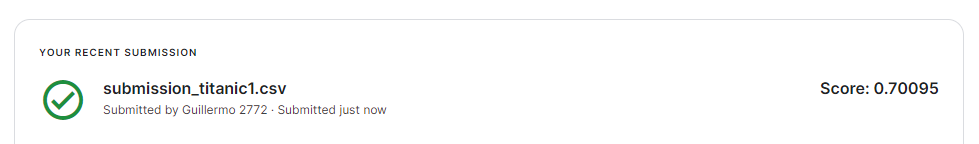

<span style='color:blue'>Submission2:
    
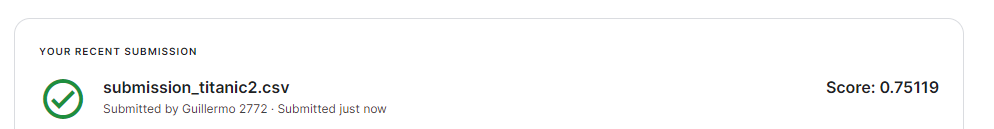

<span style='color:blue'>Submission3:
    
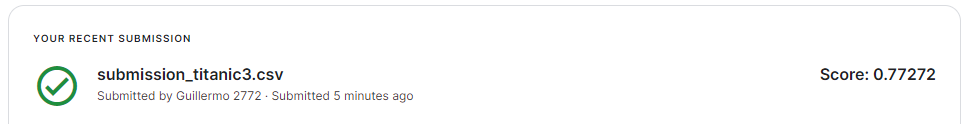

<h3><span style='color:blue'>Spaceship titanic

In [17]:
df_train = pd.read_csv('train dimension.csv')
L = list(pyk.proc_freq(df_train, 'Transported').frequency)
print('Trasportados: {}. No trasportados: {}'.format(L[1], L[0]))

Trasportados: 4378. No trasportados: 4315


In [18]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<span style='color:blue'>Ponemos el target como 0 o 1

In [19]:
df_train['Transported'] = np.where(df_train['Transported'] == True, 1, 0)

In [20]:
X, y = df_train.drop('Transported', axis=1), df_train.Transported.values

<span style='color:blue'>Probamos un primer modelo excluyendo `PassengerId` y `Name`

In [21]:
modelo_spaceship1 = pyk.autoscorecard(excluded_vars=['PassengerId', 'Name'], selection_max_iters=3).fit(X, y)

Particionado 70-30 estratificado en el target terminado.
------------------------------------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------------------------------------
Variables no agrupadas: ['CryoSleep', 'Destination', 'Cabin', 'VIP', 'HomePlanet']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cuidado! Estas variables son booleanas, para usarlas transfórmalas a string antes: ['CryoSleep', 'VIP']
------------------------------------------------------------------------------------------------------------------------------------------------------
Step 01 | Time - 0:00:00.403142 | p-value = 5.43e-159 | Gini t

<span style='color:blue'> Si te fijas el log nos avisa de que las variable `VIP` y `CryoSleep` son booleanas y nos recomienda pasarlas a string para que se puedan usar (Memento no soporta variables booleanas)

In [22]:
X['CryoSleep'] = X['CryoSleep'].astype('str')
X['VIP'] = X['VIP'].astype('str')

In [23]:
modelo_spaceship1 = pyk.autoscorecard(excluded_vars=['PassengerId', 'Name']).fit(X, y)

Particionado 70-30 estratificado en el target terminado.
------------------------------------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------------------------------------
Variables no agrupadas: ['Destination', 'Cabin', 'VIP', 'HomePlanet']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cuidado, has puesto un valor numero máximo de iteraciones (12) superior al número de variables candidatas (7)
------------------------------------------------------------------------------------------------------------------------------------------------------
Step 01 | Time - 0:00:00.368672 | p-value = 6.71e-242 | Gini train = 

<span style='color:blue'>La variable `VIP` siguen sin agruparse porque tiene una categoria con más del 95% de población y por tanto entre el resto no suman más de un 5%

In [24]:
pyk.proc_freq(df_train, 'VIP')

,frequency,percent
VIP,,
False,8291,0.953756
True,199,0.022892
NaN,203,0.023352


<span style='color:blue'>Al igual que antes, tenemos un tremendo desplome del train al test... Miramos a ver si alguna de las variables tiene un IV muy alto y es demasiado granular

In [25]:
modelo_spaceship1.tabla_ivs.head(3)

,variable,iv
0,CryoSleep,0.955003
2,RoomService,0.633759
1,Spa,0.626870


<span style='color:blue'>`Cabin` es súper sospechosa (debe haber casi una cabina por individuo!)

In [26]:
print('Valores distintos variable Cabin: {}'.format(len(X['Cabin'].value_counts())))

Valores distintos variable Cabin: 6560


In [27]:
modelo_spaceship2 = pyk.autoscorecard(excluded_vars=['PassengerId', 'Name', 'Cabin']).fit(X, y)

Particionado 70-30 estratificado en el target terminado.
------------------------------------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------------------------------------
Variables no agrupadas: ['Destination', 'VIP', 'HomePlanet']
------------------------------------------------------------------------------------------------------------------------------------------------------
Cuidado, has puesto un valor numero máximo de iteraciones (12) superior al número de variables candidatas (7)
------------------------------------------------------------------------------------------------------------------------------------------------------
Step 01 | Time - 0:00:00.451551 | p-value = 6.71e-242 | Gini train = 43.60% | 

<span style='color:blue'>En esta segunda versión ya no tenemos sobreajuste... Hacemos las predicciones y subimos a Kaggle! 🚀

In [28]:
df_test = pd.read_csv('test dimension.csv')
df_test['CryoSleep'] = df_test['CryoSleep'].astype('str')
df_test['VIP'] = df_test['VIP'].astype(str)

In [29]:
prediction1 = modelo_spaceship1.transform(df_test, id_columns=['PassengerId'])\
.rename(columns={'prediction': 'Transported'})[['PassengerId', 'Transported']]
prediction1['Transported'] = np.where(prediction1['Transported'] == 1, True, False)
prediction1.to_csv('submission_spaceship1.csv', index=False)

prediction2 = modelo_spaceship2.transform(df_test, id_columns=['PassengerId'])\
.rename(columns={'prediction': 'Transported'})[['PassengerId', 'Transported']]
prediction2['Transported'] = np.where(prediction2['Transported'] == 1, True, False)
prediction2.to_csv('submission_spaceship2.csv', index=False)

<span style='color:blue'>Submission1:

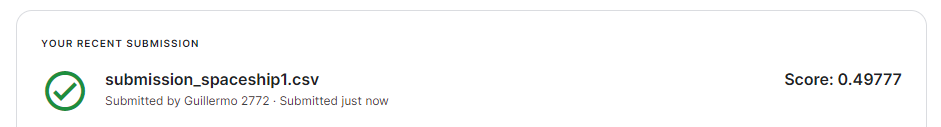

<span style='color:blue'>Submission2:
    
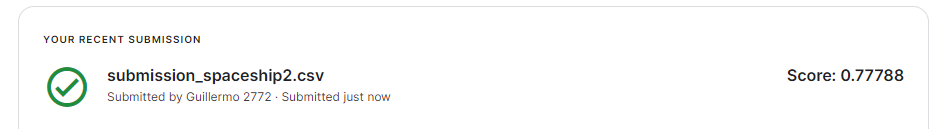

<span style='color:blue'>Pintamos la scorecard del modelo2

In [30]:
pyk.pretty_scorecard(modelo_spaceship2, color1='yellow')

,Variable,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV,Raw score,Aligned score
0,CryoSleep,['True'],2098,0.344782,378,1720,0.819828,-1.500395,0.654186,0.443921,70
1,CryoSleep,"['nan', 'False']",3987,0.655218,2642,1345,0.337346,0.689933,0.300817,-0.204130,89
2,RoomService,Missing,126,0.020707,73,53,0.420635,0.334958,0.002305,-0.208064,89
3,RoomService,"(-inf, 0.50)",3870,0.635990,1408,2462,0.636176,-0.544013,0.183353,0.337921,73
4,RoomService,"[0.50, 29.50)",462,0.075924,309,153,0.331169,0.717694,0.037607,-0.445805,96
5,RoomService,"[29.50, 353.50)",617,0.101397,386,231,0.374392,0.528210,0.027703,-0.328105,92
6,RoomService,"[353.50, 729.50)",382,0.062777,300,82,0.214660,1.311854,0.095220,-0.814875,106
7,RoomService,"[729.50, inf)",628,0.103205,544,84,0.133758,1.882923,0.287572,-1.169601,117
8,Spa,Missing,124,0.020378,60,64,0.516129,-0.049748,0.000050,0.023817,82
9,Spa,"(-inf, 0.50)",3737,0.614133,1363,2374,0.635269,-0.540097,0.174574,0.258574,76
